In [1]:
import os

import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
from PIL import Image
from pathlib import Path

from tqdm.auto import tqdm
import multiprocessing as mp

from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

## MODEL BUILDING PLAN

- Setup Environment: Install the required libraries, setup your Python environment.

- Dataset Acquisition: Download the dataset Flickr8k. Explore the data and understand its structure.

- Preprocessing: Implement the preprocessing steps for images (resizing, normalization) and text (tokenization).

- Model Setup: Setup the Vision Transformer and GPT-2 models using the Hugging Face Transformers library. Understand their inputs and outputs.

- Training Loop: Implement the training loop where you extract features from images using Vision Transformer, and use those features as input to the GPT-2 model for generating captions.

- Model Evaluation: Implementation of evaluation metrics like BLEU, METEOR, etc., to quantify the performance of the model.

- Model Optimization: Optimize the model by experimenting with different hyperparameters, model architectures, and other relevant aspects.

In [4]:
from dataclasses import dataclass
import multiprocessing as mp

@dataclass
class ModelConfig:
    encoder: str = "google/vit-base-patch16-224"
    decoder: str = "gpt2"

@dataclass
class TrainingConfig:
    batch_size: int = 8
    val_batch_size: int = 8
    val_epochs: int = 1
    learning_rate: float = 5e-5
    seed: int = 42
    epochs: int = 3

@dataclass
class DataConfig:
    max_len: int = 128
    summary_len: int = 20
    train_pct: float = 0.95
    num_workers: int = mp.cpu_count()
    img_size: tuple = (224, 224)

@dataclass
class RegularizationConfig:
    weight_decay: float = 0.01
    label_mask: int = -100
    top_k: int = 1000
    top_p: float = 0.95

@dataclass
class NormalizationConfig:
    mean: tuple = (0.485, 0.456, 0.406)
    std: tuple = (0.229, 0.224, 0.225)

os.environ["WANDB_DISABLED"] = "true"

## VIT Feature Extractor and Tokenizer

In [5]:
def build_inputs_with_special_tokens(token_ids_0, token_ids_1=None):
    """
    Builds inputs with special tokens.

    Args:
        token_ids_0 (list): The list of token IDs for the first sequence.
        token_ids_1 (list, optional): The list of token IDs for the second sequence.

    Returns:
        outputs (list): The list of token IDs with special tokens.
    """
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [6]:
def initialize_feature_extractor_and_tokenizer(encoder, decoder):
    """
    Initializes a feature extractor and tokenizer.

    Args:
        encoder (str): The model name or path for the encoder.
        decoder (str): The model name or path for the decoder.

    Returns:
        feature_extractor (ViTFeatureExtractor): The initialized feature extractor.
        tokenizer (AutoTokenizer): The initialized tokenizer with pad token set to unknown token.
    """
    feature_extractor = ViTFeatureExtractor.from_pretrained(encoder)
    tokenizer = AutoTokenizer.from_pretrained(decoder)
    tokenizer.pad_token = tokenizer.unk_token
    
    return feature_extractor, tokenizer

feature_extractor, tokenizer = initialize_feature_extractor_and_tokenizer(ModelConfig.encoder, ModelConfig.decoder)

D:\Anaconda\envs\dlenv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manis\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
D:\Anaconda\envs\dlenv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecat

## Load and Preprocess the Dataset

### load dataset and preprocess the images and captions.

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_and_split_data(file_path, test_size=0.2):
    df = pd.read_csv(file_path)
    train_df, val_df = train_test_split(df, test_size=test_size)
    return train_df, val_df, df

train_df, val_df, df = load_and_split_data("./Data/captions.txt")
df.head(2)

image   
0  1000268201_693b08cb0e.jpg  \
1  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .

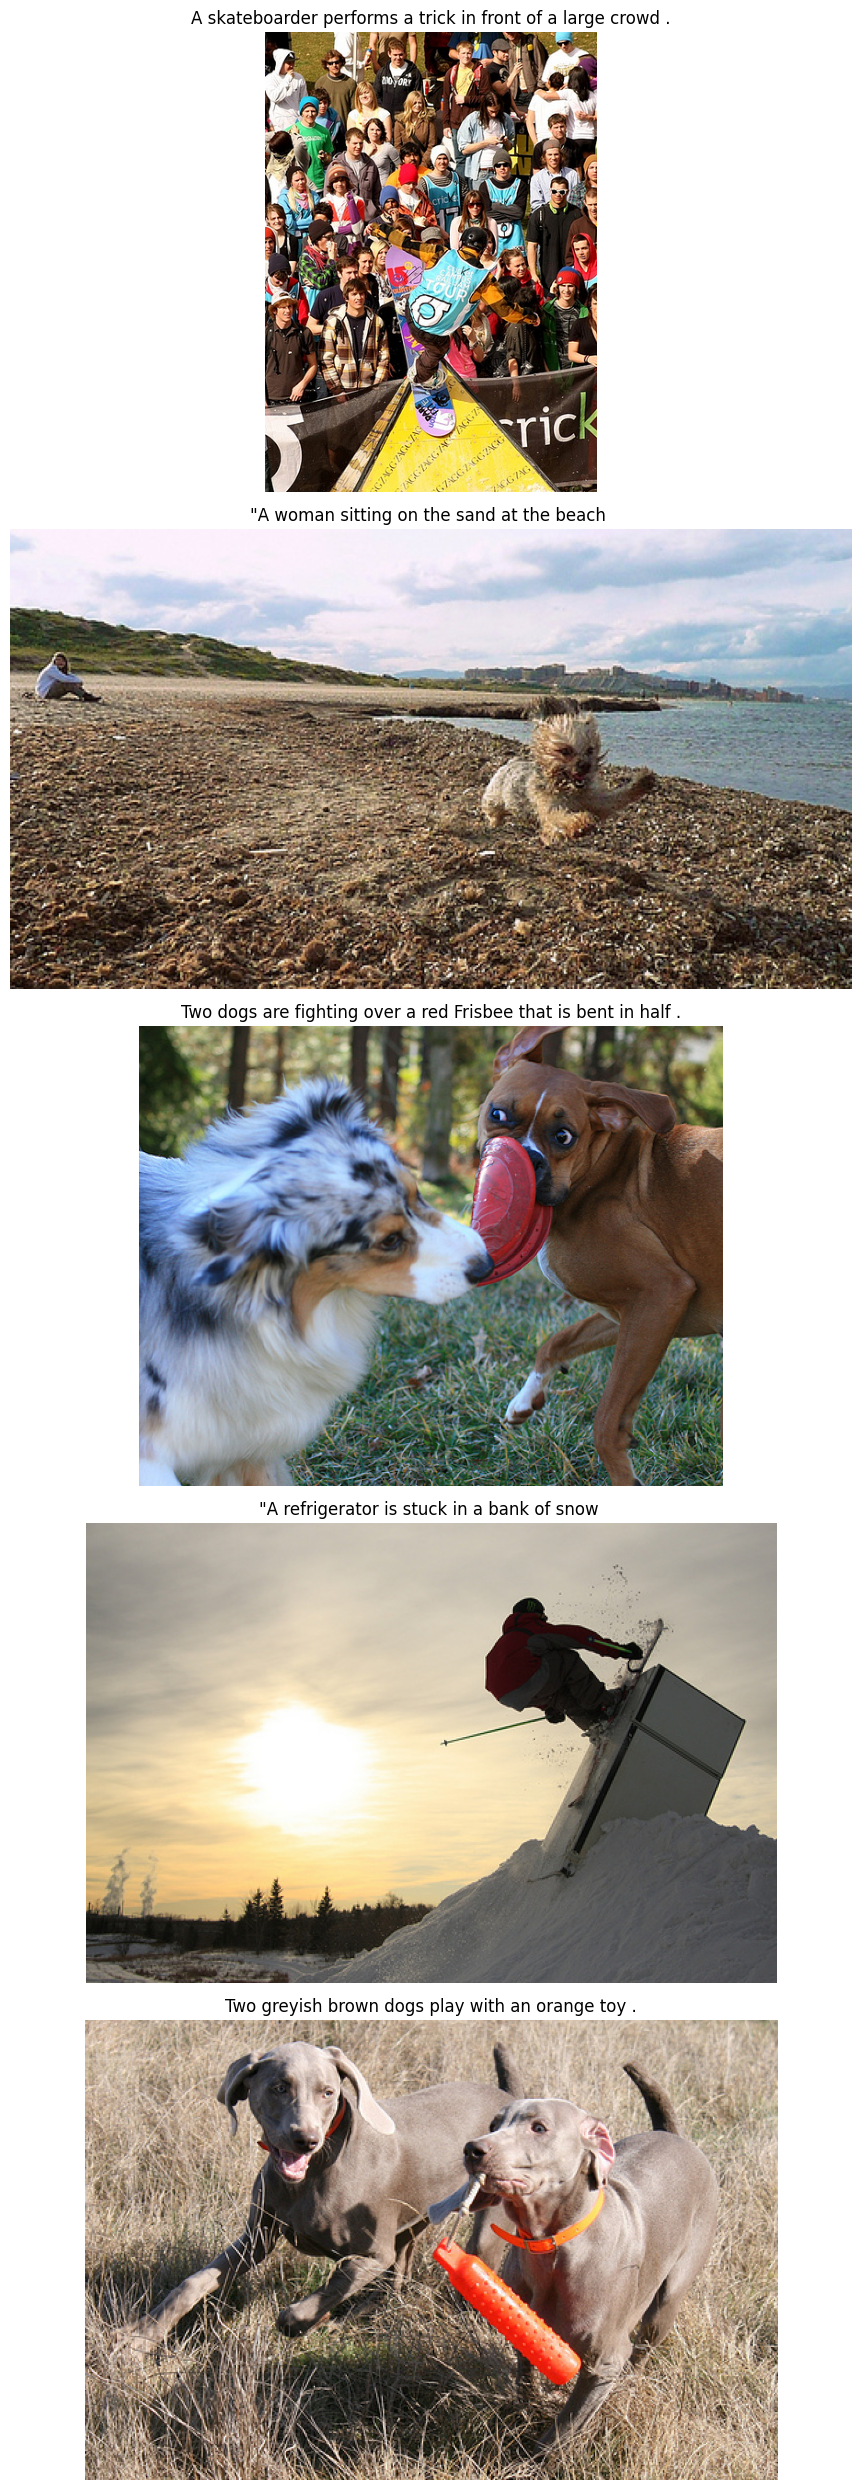

In [20]:
import matplotlib.image as mpimg

captions_df = pd.read_csv('./Data/captions.txt', delimiter='\t', header=None, names=['image', 'caption'])

image_dir = './Data/Images'

# Number of images to display
num_images = 5

# Randomly sample images
sampled_images = captions_df.sample(num_images)

# Plot images and their captions
fig, axes = plt.subplots(nrows=num_images, figsize=(10, 5*num_images))

for ax, (img_name, caption) in zip(axes, sampled_images.values):
    img_path = os.path.join(image_dir, img_name.split(',')[0])
    caption = img_name.split(',')[1]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(caption)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, root_dir, tokenizer, feature_extractor, transform=None, max_length=50):
        self.dataframe = dataframe
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        caption = self.dataframe.caption.iloc[idx]
        image = self.dataframe.image.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")
#         img = Image.fromarray(image_array.astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        tokenized_captions = self.tokenizer(caption, padding='max_length', max_length=self.max_length).input_ids
        captions = [token if token != self.tokenizer.pad_token_id else -100 for token in tokenized_captions]
        
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions), "caption":caption}

## Creating  Dataloaders


In [9]:
from torchvision import io, transforms
transforms = transforms.Compose(
    [
        transforms.Resize(DataConfig.img_size), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.0, 
            std=1.5
        )
   ]
)

train_dataset = ImageCaptionDataset(train_df, root_dir = "./Data/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImageCaptionDataset(val_df , root_dir = "./Data/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

## Vision Transformer for Feature Extraction

### Using pre-trained Vision Transformer (ViT) model from the Transformers library to extract features from our images

In [21]:
from transformers import ViTFeatureExtractor, ViTModel

import warnings
warnings.filterwarnings("ignore")

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(ModelConfig.encoder, ModelConfig.decoder)
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

In [22]:
def configure_model(tokenizer, encoder, decoder, max_length=128, early_stopping=True, no_repeat_ngram_size=3, length_penalty=2.0, num_beams=4):
    """
    Configures and returns a VisionEncoderDecoderModel.

    Args:
        tokenizer (AutoTokenizer): The tokenizer for the model.
        encoder (str): The model name or path for the encoder.
        decoder (str): The model name or path for the decoder.
        max_length (int): The maximum sequence length.
        early_stopping (bool): Whether to stop beam search when all hypotheses reach the end of string token.
        no_repeat_ngram_size (int): The maximum size of ngrams that must not appear more than once.
        length_penalty (float): Exponential penalty to the sequence length.
        num_beams (int): Number of beams for beam search.

    Returns:
        model (VisionEncoderDecoderModel): The configured VisionEncoderDecoderModel.
    """

    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder, decoder)

    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.vocab_size = model.config.decoder.vocab_size
    model.config.eos_token_id = tokenizer.sep_token_id
    model.config.decoder_start_token_id = tokenizer.bos_token_id
    model.config.max_length = max_length
    model.config.early_stopping = early_stopping
    model.config.no_repeat_ngram_size = no_repeat_ngram_size
    model.config.length_penalty = length_penalty
    model.config.num_beams = num_beams

    return model

model = configure_model(tokenizer, ModelConfig.encoder, ModelConfig.decoder)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly ini

## Setting up Training Argumments

In [24]:
def setup_training_args(output_dir, config, learning_rate=5e-5, evaluation_strategy="epoch", logging_steps=1024, save_steps=2048, warmup_steps=1024, do_train=True, do_eval=True, overwrite_output_dir=True, save_total_limit=1):
    """
    Sets up the training arguments for the sequence-to-sequence model.

    Args:
        output_dir (str): The directory to save model checkpoints and predictions.
        config (object): The configuration object with training parameters.
        learning_rate (float): The learning rate for the optimizer.
        evaluation_strategy (str): The evaluation strategy during training.
        logging_steps (int): The number of steps between each logging.
        save_steps (int): The number of steps between each checkpoint save.
        warmup_steps (int): The number of steps for the warmup phase.
        do_train (bool): Whether to run training.
        do_eval (bool): Whether to run evaluation.
        overwrite_output_dir (bool): Overwrite the content of the output directory.
        save_total_limit (int): The limit on the total amount of checkpoints.

    Returns:
        training_args (Seq2SeqTrainingArguments): The training arguments for the sequence-to-sequence model.
    """
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=config.val_batch_size,
        predict_with_generate=True,
        evaluation_strategy=evaluation_strategy,
        do_train=do_train,
        do_eval=do_eval,
        logging_steps=logging_steps,  
        save_steps=save_steps, 
        warmup_steps=warmup_steps,  
        learning_rate = learning_rate,
        num_train_epochs = config.epochs, 
        overwrite_output_dir=overwrite_output_dir,
        save_total_limit=save_total_limit,
    )
    return training_args

training_args = setup_training_args('VIT_large_gpt2', TrainingConfig)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Training Loop

### Training loop where the combination  of  Vision Transformer (for image feature extraction) and GPT-2 model (for caption generation). loss function (loss_fn) and optimizer (optimizer) 

In [25]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1050


In [26]:
import datasets
# datasets.list_metrics()
# !pip install rouge-score

In [27]:
rouge = datasets.load_metric("rouge")

Using the latest cached version of the module from C:\Users\manis\.cache\huggingface\modules\datasets_modules\metrics\rouge\08e5f021b5761265deaafbf424e57913106427f546189fe3f934069dd32c153f (last modified on Sun Aug 20 19:45:12 2023) since it couldn't be found locally at rouge, or remotely on the Hugging Face Hub.


In [28]:
# rouge = datasets.load_metric("rouge")

def compute_metrics(pred, tokenizer, rouge):
    """
    Computes metrics for the predictions.

    Args:
        pred (PredictionOutput): The model's prediction outputs.
        tokenizer (Tokenizer): The tokenizer used to decode the predictions and labels.
        rouge (Rouge): The Rouge metric for evaluation.

    Returns:
        metrics (dict): A dictionary with the calculated metrics.
    """
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [22]:
class CustomTrainer(Seq2SeqTrainer):
    """
    Custom Seq2SeqTrainer for the training task.
    """
    def __init__(self, tokenizer, model, training_args, compute_metrics, train_dataset, eval_dataset, data_collator):
        """
        Initializes the CustomTrainer instance.

        Args:
            tokenizer (CustomAutoTokenizer): The tokenizer with special tokens.
            model (VisionEncoderDecoderModel): The model to train.
            training_args (Seq2SeqTrainingArguments): The training arguments.
            compute_metrics (function): The function to compute metrics.
            train_dataset (Dataset): The training dataset.
            eval_dataset (Dataset): The evaluation dataset.
            data_collator (DataCollator): The data collator.
        """
        super().__init__(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            data_collator=data_collator
        )
    
    def train(self):
        """
        Starts the training process.
        """
        super().train()

# Instantiate the trainer
model_trainer = CustomTrainer(
    tokenizer=tokenizer,
    model=model,
    training_args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

model_trainer.train()

TypeError: compute_metrics() missing 2 required positional arguments: 'tokenizer' and 'rouge'

## Model Save 

In [33]:
save_directory = "model_v1"

In [24]:
# #save Model
# model_trainer.save_model(save_directory)

# # Save the tokenizer
# tokenizer.save_pretrained(save_directory)

# # Save the feature extractor
# feature_extractor.save_pretrained(f"{save_directory}/feature_extractor")

['model_v1/feature_extractor\\preprocessor_config.json']

## Model Load Back

In [47]:
model = VisionEncoderDecoderModel.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)
feature_extractor = ViTFeatureExtractor.from_pretrained(f"{save_directory}/feature_extractor")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [16]:
## load model from cloud
# from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
# import torch
# from PIL import Image

# model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

outputs : 
 [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x15C5A8B2190>] ['a man standing next to a brown horse near a fire hydrant']


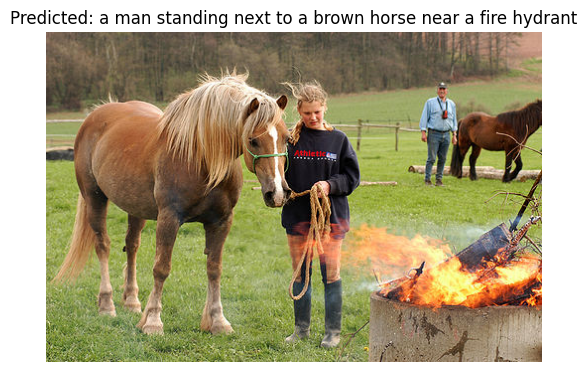

In [57]:
import matplotlib.pyplot as plt
from PIL import Image

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
        images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    model.eval()
    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return images, preds

def display_predictions(image_paths):
    images, predictions = predict_step(image_paths)
    
    print('outputs : \n', images, predictions)

    for img, pred in zip(images, predictions):
        plt.imshow(img)
        plt.title(f"Predicted: {pred}")
        plt.axis("off")
        plt.show()

# Example
display_predictions(['./Data/Images/10815824_2997e03d76.jpg'])

outputs : 
 [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x306 at 0x15C5AD77580>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x15C5AC82670>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x362 at 0x15C5AC82F10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x15C5AC82CA0>] ['young men playing a game of soccer', 'a man standing on top of a rock looking at the sky', 'a man riding a bike down a snow covered road', 'a brown horse and a black horse standing on a beach']


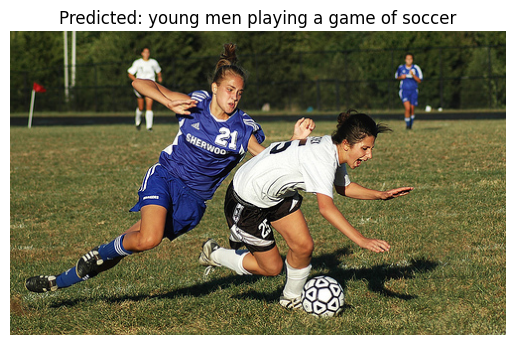

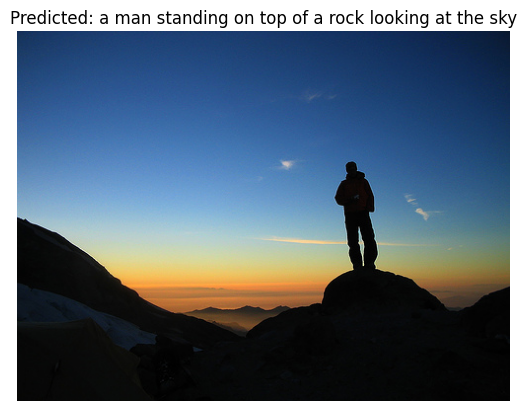

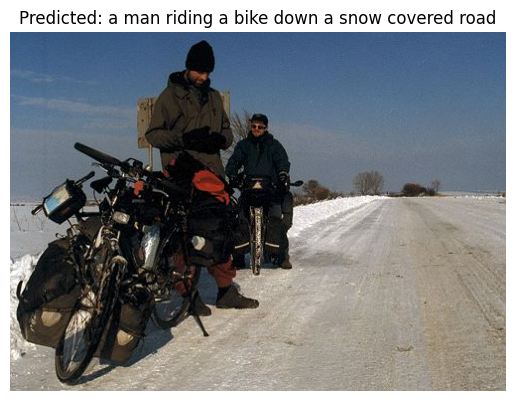

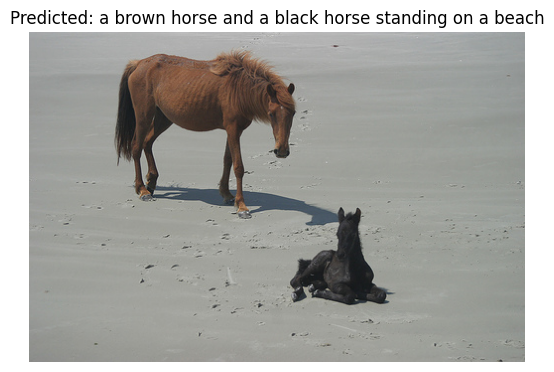

In [58]:
display_predictions(['./Data/Images/47871819_db55ac4699.jpg',
                    './Data/Images/58368365_03ed3e5bdf.jpg',
                    './Data/Images/95734035_84732a92c1.jpg',
                    './Data/Images/124195430_d14028660f.jpg'])

## Model In Action

In [60]:
# !pip install gradio

In [6]:
import gradio as gr
from PIL import Image


def caption_image(input_image: Image.Image):
    """
    Generate a caption for the input image using the trained model.

    Args:
    - input_image (Image.Image): Input image to caption.

    Returns:
    - str: Generated caption for the input image.
    """
    # Preprocess the image for the model
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)), 
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )
    img_tensor = transform(input_image)
    pixel_values = feature_extractor(img_tensor.unsqueeze(0), return_tensors="pt").pixel_values

    # Generate a caption for the image
    outputs = model.generate(pixel_values, max_length=50, num_return_sequences=1, num_beams=5)
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return caption

def get_caption(images):
    max_length = 16
    num_beams = 4
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    caption = [pred.strip() for pred in preds][0]
    return caption

# Create Gradio UI
interface = gr.Interface(fn=get_caption, inputs="image", outputs="text")
interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Image Search Local

## Text to Image Search

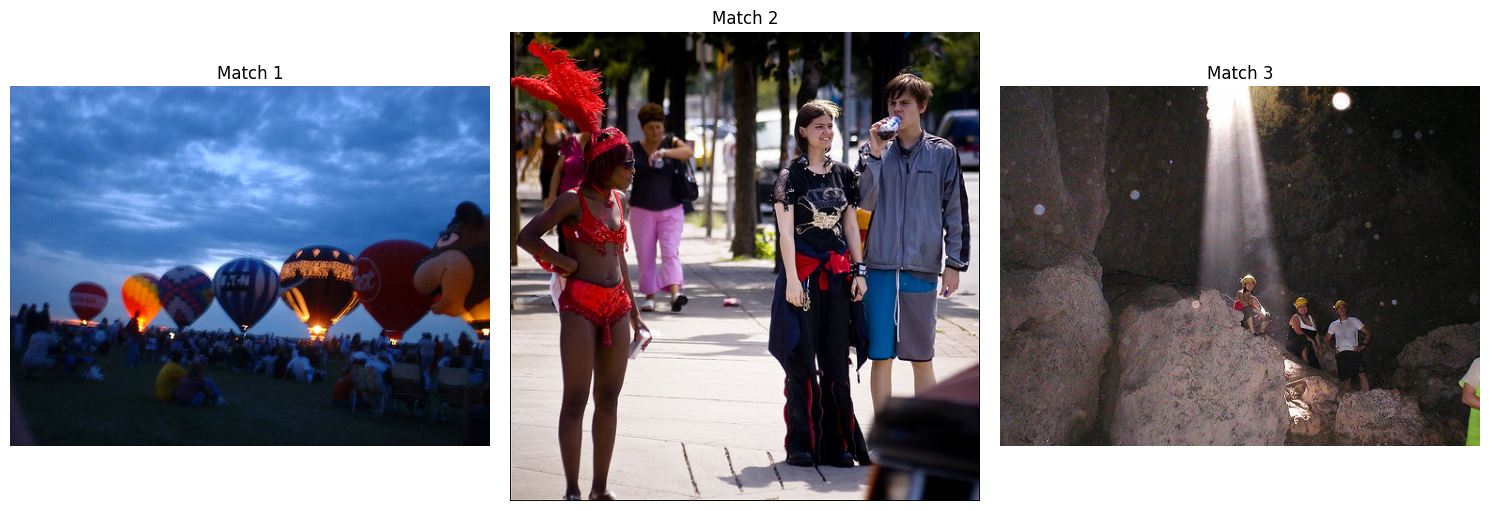

In [31]:
#  Pre-process and Caption the entire Image Database
def caption_database(image_folder, limit=100):
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.jpg', '.png'))][:limit]
    _, captions = predict_step(image_paths)
    
    return dict(zip(image_paths, captions))


#  Build TF-IDF based index
def build_index(captions):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(list(captions.values()))
    return vectorizer, tfidf_matrix

# Query processing
def search(query, vectorizer, tfidf_matrix, image_captions):
    query_vec = vectorizer.transform([query])
    cosine_sim = linear_kernel(query_vec, tfidf_matrix).flatten()
    related_image_paths = sorted(((score, path) for path, score in zip(image_captions.keys(), cosine_sim)), reverse=True)[:10]  # Top 10 matches
    
    return [path for _, path in related_image_paths]


# Example usage
image_folder = './Data/Images/'
image_captions = caption_database(image_folder)
vectorizer, tfidf_matrix = build_index(image_captions)

query = "a group of people"
result_image_paths = search(query, vectorizer, tfidf_matrix, image_captions)

matches = result_image_paths[:3]
fig, axs = plt.subplots(1, len(matches), figsize=(15, 5))

for i, path in enumerate(matches):
    img = Image.open(path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Match {i+1}")

plt.tight_layout()
plt.show()

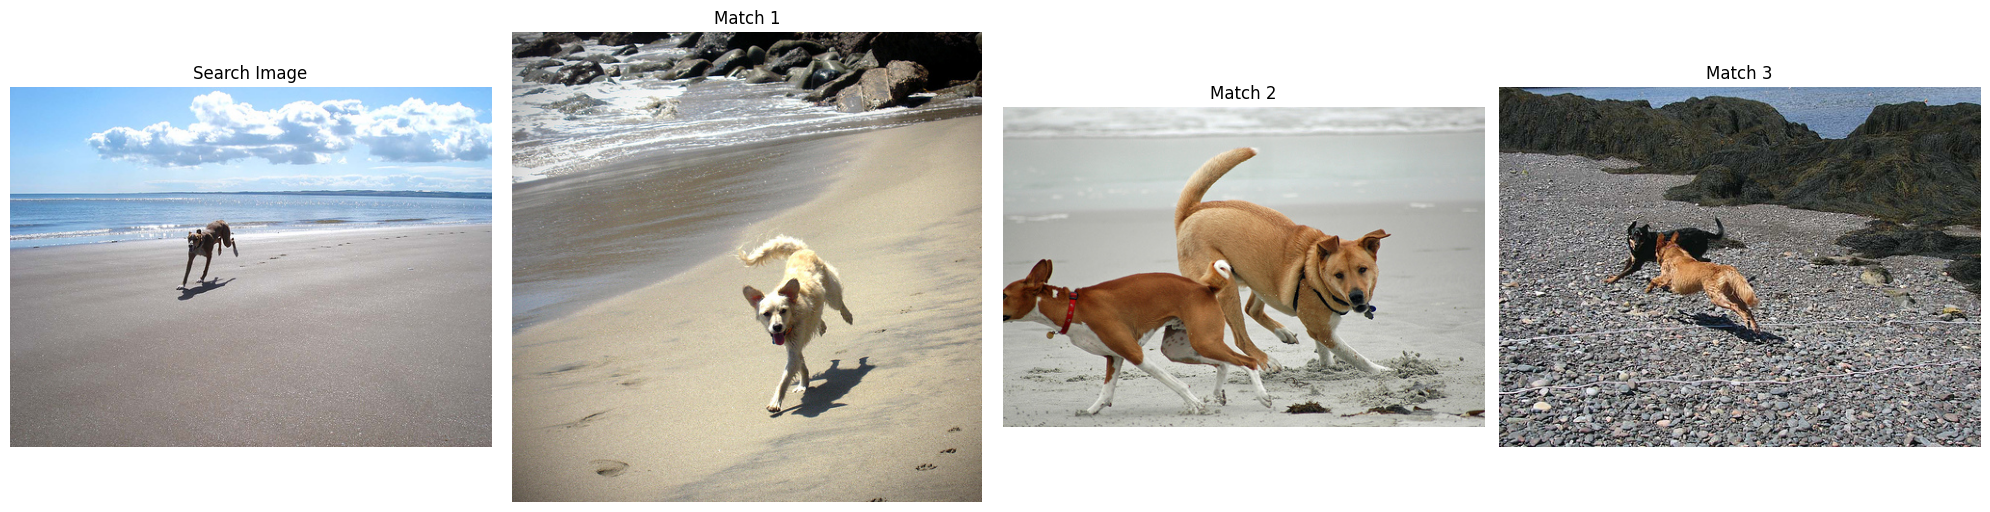

In [35]:
def extract_embeddings(image_paths):
    images = [Image.open(p).convert("RGB") for p in image_paths]
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    with torch.no_grad():
        embeddings = model.encoder(pixel_values).last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

def image_search(query_image_path, database_embeddings, database_paths):
    query_embedding = extract_embeddings([query_image_path])
    similarities = cosine_similarity(query_embedding, database_embeddings)
    top_indices = np.argsort(similarities[0])[::-1][:3]  # Getting top 3
    return [database_paths[i] for i in top_indices]


def display_top_matches(query_image_path, result_image_paths):
    # Total number of subplots will be top matches + 1 for the query image
    fig, axs = plt.subplots(1, len(result_image_paths) + 1, figsize=(20, 5))
    
    # Display the query image
    query_img = Image.open(query_image_path)
    axs[0].imshow(query_img)
    axs[0].axis('off')
    axs[0].set_title("Search Image")
    
    # Display the top matches
    for i, path in enumerate(result_image_paths):
        img = Image.open(path)
        axs[i+1].imshow(img)
        axs[i+1].axis('off')
        axs[i+1].set_title(f"Match {i+1}")
    
    plt.tight_layout()
    plt.show()

# Test the search with a query image
image_dir = "./Data/Images/"
all_image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)][:100]
database_embeddings = extract_embeddings(all_image_paths)

# Test the search with a query image
query_image_path = "./Data/Images/140430106_2978fda105.jpg"
top_matches = image_search(query_image_path, database_embeddings, all_image_paths)

display_top_matches(query_image_path, top_matches)